Volume 3: PCA_LSI
Name:
Class:
Date:

In [1]:
import os
import string
import numpy as np
from math import log
from scipy import sparse
from sklearn import datasets
from scipy import linalg as la
from collections import Counter
from matplotlib import pyplot as plt
from scipy.sparse import linalg as spla
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


In [54]:
def prob1():
    """Recreates the plot shown
    in Figure 1.4 by performing PCA on the iris dataset,
    keeping the first two principal components."""
    # Load the iris dataset
    iris = datasets.load_iris()

    
    # Calculate the centered data
    X = iris.data
    X_means = X.mean(axis=0)
    Y = X - X_means
    
    # Calculate SVD of Y
    U, S, VT = la.svd(Y, full_matrices = False)

    # Calculate Yhat using the first two elements of V
    V = VT.T[:,:2]
    Yhat = Y @ V
    
    # Scatter plot the reduced dimensional data
    setosas = Yhat[iris.target==0]
    versicolor = Yhat[iris.target==1]
    virginica = Yhat[iris.target==2]
    
    plt.scatter(*setosas.T,label="Setosa")
    plt.scatter(*versicolor.T,label="Versicolor")
    plt.scatter(*virginica.T,label="Virginica")
    plt.legend()
    plt.xlim(-4,4)
    plt.ylim(-4,4)
    plt.title("Iris Dataset, PCA Dimension Reduction")
    plt.ylabel("Second Principal Component")
    plt.xlabel("First Principal Component")
    plt.show()



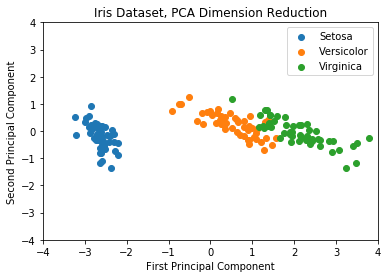

In [55]:
prob1()

In [52]:
def similar(i, Xhat):
    """
    Takes a document and returns the index of
    two documents. The one that is the most similar 
    and the one that is the least similar.
    
    Parameters:
    i index of a document
    Xhat decomposed data
    
    Returns:
    index_min: index of the document most similar to document i
    index_max: index of the document least similar to document i
    """
    # Find the document i
    Xi = Xhat[i]
    
    # Calculate the similarity of i to each other document j
    sim = (Xhat @ Xi) / la.norm(Xhat,axis=1)
    print(sim.shape)
    # Sort the distances
    sorts = np.argsort(sim)
    return sorts[-2],sorts[0] # distance to self will always be -1

In [53]:
def document_converter():
    '''
    Converts speech documents into an n by m array where m is the number 
    of vocabulary words and n is the number of documents
    
    Returns:
    X sparse matrix (n x m): Each row represents a document
    paths (list): list where each element is a speech path eg: path[0] is './Addresses/1990-Bush.txt'
    '''
    # Get list of filepaths to each text file in the folder.
    folder = "./Addresses/"
    paths = [folder+p for p in os.listdir(folder) if p.endswith(".txt")]

    # Helper function to get list of words in a string.
    def extractWords(text):
        ignore = string.punctuation + string.digits
        cleaned = "".join([t for t in text.strip() if t not in ignore])
        return cleaned.lower().split()

    # Initialize vocab set, then read each file and add to the vocab set.
    vocab = set()
    for p in paths:
        with open(p, 'r') as infile:
            for line in infile:
                vocab.update(extractWords(line)) #union sets together


    # load stopwords
    with open("stopwords.txt", 'r') as f:
        stops = set([w.strip().lower() for w in f.readlines()])

    # remove stopwords from vocabulary, create ordering
    vocab = {w:i for i, w in enumerate(vocab.difference(stops))}


    counts = []      # holds the entries of X
    doc_index = []   # holds the row index of X
    word_index = []  # holds the column index of X

    # Iterate through the documents.
    for doc, p in enumerate(paths):
        with open(p, 'r') as f:
            # Create the word counter.
            ctr = Counter()
            for line in f:
                ctr.update(extractWords(line))
            # Iterate through the word counter, store counts.
            for word, count in ctr.items():
                if word in vocab:
                    word_index.append(vocab[word])
                    counts.append(count)
                    doc_index.append(doc)

    # Create sparse matrix holding these word counts.
    X = sparse.csr_matrix((counts, [doc_index, word_index]),
                           shape=(len(paths), len(vocab)), dtype=np.float)
    return X, paths

In [54]:
def prob3(speech, l=7):
    """
    Uses LSI, applied to the word count matrix X, with the first 7 principal
    components to find the most similar and least similar speeches

    Parameters:
        speech str: Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """    
    # Use provided function to get X and paths list
    X, paths = document_converter()
    
    # Find the index of the desired speech within X
    i = paths.index(speech)
    
    # Perform PCA on X, without mean-shifting, keeping l elements
    _,_,VT = spla.svds(X,k = l)
    
    Vhat = VT.T[:,:7]
    Xhat = X @ Vhat
    
    # Calculate the most and least similar
    most, least = similar(i,Xhat)
    
    return paths[most][len("./Addresses/"):], paths[least][len("./Addresses/"):]
    

In [55]:
prob3("./Addresses/1984-Reagan.txt")

(65,)


('1988-Reagan.txt', '1946-Truman.txt')

In [56]:
def weighted_document_converter():
    '''
    Converts speech documents into an n by m array where m is the number 
    of vocabulary words and n is the number of documents. It gives weights
    to the most important words in the vocabulary.
    
    Returns:
    X sparse matrix (n x m): Each row represents a document
    paths (list): list where each element is a speech path eg: path[0] is './Addresses/1990-Bush.txt'
    '''
    # Get list of filepaths to each text file in the folder.
    folder = "./Addresses/"
    paths = [folder+p for p in os.listdir(folder) if p.endswith(".txt")]

    # Helper function to get list of words in a string.
    def extractWords(text):
        ignore = string.punctuation + string.digits
        cleaned = "".join([t for t in text.strip() if t not in ignore])
        return cleaned.lower().split()

    # Initialize vocab set, then read each file and add to the vocab set.
    vocab = set()
    for p in paths:
        with open(p, 'r') as infile:
            for line in infile:
                vocab.update(extractWords(line))


    # load stopwords
    with open("stopwords.txt", 'r') as f:
        stops = set([w.strip().lower() for w in f.readlines()])

    # remove stopwords from vocabulary, create ordering
    vocab = {w:i for i, w in enumerate(vocab.difference(stops))}

    t = np.zeros(len(vocab))
    counts = []
    doc_index = []
    word_index = []

    # get doc-term counts and global term counts
    for doc, path in enumerate(paths):
        with open(path, 'r') as f:
            # create the word counter
            ctr = Counter()
            for line in f:
                words = extractWords(line)
                ctr.update(words)
            # iterate through the word counter, store counts
            for word, count in ctr.items():
                if word in vocab:
                    word_ind = vocab[word]
                    word_index.append(word_ind)
                    counts.append(count)
                    doc_index.append(doc)
                    t[word_ind] += count

    X = sparse.csr_matrix((counts, [doc_index, word_index]),
                           shape=(len(paths), len(vocab)), dtype=np.float).todense()
    
    #Problem 4 Get global weights.
    sum_j = X.sum(axis=0)
    pij = np.array(X/sum_j)
    gj = 1 + (np.multiply(pij, np.log(pij + 1)) / np.log(len(pij))).sum(axis=0)
    
    # Calculate A
    A = np.multiply(gj, np.log(X + 1))
    
    return sparse.csr_matrix(A), paths
    
    

In [57]:
def prob5(speech, l=7):
    """
    Uses LSI, applied to the globally weighted word count matrix A, with the
    first 7 principal components to find the most similar and least similar speeches

    Parameters:
        speech str: Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """
    # Use provided function to get X and paths list
    X, paths = weighted_document_converter()
    
    # Find the index of the desired speech within X
    i = paths.index(speech)
    
    # Perform PCA on X, without mean-shifting, keeping l elements
    pca = PCA(n_components = l)
    Xhat = pca.fit_transform(X.todense())
    
    # Calculate the most and least similar
    most, least = similar(i,Xhat)
    
    return paths[most][len("./Addresses/"):], paths[least][len("./Addresses/"):]
    

In [58]:
prob5("./Addresses/1993-Clinton.txt")

(65,)


('1995-Clinton.txt', '1951-Truman.txt')

In [132]:
def prob6():
    '''
    Create a pipeline and grid search to find the best combination 
    of PCA truncation and random forest classifier for the iris 
    dataset. Return the best paramters and score in a tuple. 

    Returns:
    search.best_params_, search.best_score_
    ''' 
    # Load and split iris dataset
    iris = datasets.load_iris()
    X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target)
    
    mean = X_train.mean(axis=0)
    Xhat_train, Xhat_test = X_train - mean, X_test - mean 
    
    # Create pipeline
    pipe = Pipeline([("scaler",StandardScaler()),
                     ("pca",PCA()),
                     ("clf",RandomForestClassifier())])
    
    pipe_param_grid = {"scaler__with_mean":[True,False],
                       "scaler__with_std":[True,False],
                       "pca__n_components":[1,2,3,4],
                       "clf__n_estimators":[1,2,3,4],
                       "clf__max_depth":[1,2,3,4]}
    
    pipe_gs = GridSearchCV(pipe, pipe_param_grid, cv=4,n_jobs=-1).fit(X_train, y_train)
    
    return pipe_gs.best_params_, pipe_gs.best_score_
    
    

In [133]:
prob6()

({'clf__max_depth': 2,
  'clf__n_estimators': 1,
  'pca__n_components': 1,
  'scaler__with_mean': False,
  'scaler__with_std': False},
 0.9642857142857143)